In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot
import numpy as np

In [2]:
# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)
registry = {}

NR_BARGES = 15

In [3]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
    ),
    {},
)

In [4]:
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)

In [5]:
amount = 1000

data_from_site = {"env": my_env,
                  "name": "from_site",
                  "geometry": location_from_site,
                  "capacity": amount,
                  "level": amount,
                  "nr_resources":1
                 }
from_site = Site(**data_from_site)

location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
data_to_site = {"env": my_env,
                "name": "to_site",
                "geometry": location_to_site,
                "capacity": amount,
                "level": 0,
                "nr_resources":4
               }
to_site = Site(**data_to_site)

In [6]:
vessels = {}

for i in range(NR_BARGES):
    vessels[f"vessel{i}"] = TransportProcessingResource(
        env=my_env,
        name=f"barge{i}",
        geometry=location_from_site, 
        capacity=10,
        compute_v=lambda x: 10
    )
cutter = TransportProcessingResource(
    env=my_env,
    name=f"cutter",
    geometry=location_from_site, 
    capacity=10,
    compute_v=lambda x: 10
)

In [7]:
activities = {}
for i in range(NR_BARGES):
    amount = np.random.randint(3,10)
    duration=np.random.randint(10,55)
    
    requested_resources={}
    activities[f"activity{i}"] = model.WhileActivity(
        env=my_env,
        name=f"while_sequential_activity_subcycle{i}",
        registry=registry,
        sub_processes=[model.SequentialActivity(
            env=my_env,
            name=f"sequential_activity_subcycle{i}",
            registry=registry,
            sub_processes=[
                model.BasicActivity(
                    env=my_env,
                    name=f"basic activity{i}",
                    registry=registry,
                    duration=duration,
                    additional_logs=[vessels[f"vessel{i}"]],
                ),
                model.MoveActivity(
                    env=my_env,
                    name=f"sailing empty{i}",
                    registry=registry,
                    mover=vessels[f"vessel{i}"],
                    destination=from_site,
                    duration=duration,
                ),
                model.ShiftAmountActivity(
                    env=my_env,
                    name=f"loading{i}",
                    registry=registry,
                    processor=cutter,
                    origin=from_site,
                    destination=vessels[f"vessel{i}"],
                    amount=amount,
                    duration=5*amount,
                    requested_resources=requested_resources,
                ),
                model.MoveActivity(
                    env=my_env,
                    name=f"sailing full{i}",
                    registry=registry,
                    mover=vessels[f"vessel{i}"],
                    destination=to_site,
                    duration=duration,
                ),
                model.ShiftAmountActivity(
                    env=my_env,
                    name=f"unloading{i}",
                    registry=registry,
                    processor=vessels[f"vessel{i}"],
                    origin=vessels[f"vessel{i}"],
                    destination=to_site,
                    amount=amount,
                    duration=duration,
                    requested_resources=requested_resources,
                ),
            ],
        )],
        condition_event=[
            {"type": "container", 
             "concept": to_site, 
             "state": "full",
             "id_":"default_reservations"
            }
        ],
    )

In [8]:
model.register_processes(list(activities.values()))
my_env.run()

In [9]:
fig = plot.get_gantt_chart([from_site, to_site,cutter, *vessels.values()])

In [10]:
fig = plot.get_gantt_chart([from_site, to_site,cutter])

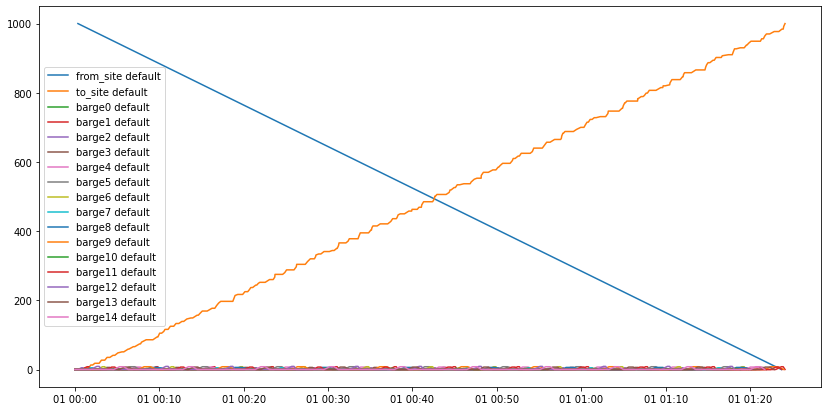

In [11]:
fig = plot.get_step_chart([from_site, to_site, *vessels.values()])

In [12]:
data = []
for i in range(NR_BARGES):
    vessel = vessels[f'vessel{i}']
    activity = activities[f'activity{i}']
    sub_act = activity.sub_processes[0].sub_processes[-1]
    log = pd.DataFrame(vessel.log)
    nr_trips = len(log[(log.ActivityID == sub_act.id) & (log.ActivityState == "START")])
    data.append({
        'name':vessel.name, 
        'trips':nr_trips, 
        'production': (sub_act.amount / (4*sub_act.duration+ 5*sub_act.amount)),
    })
pd.DataFrame(data).sort_values(by=['production'],ascending=False)

,name,trips,production
1,barge1,12,0.086957
12,barge12,11,0.082569
6,barge6,11,0.076923
2,barge2,12,0.072464
7,barge7,11,0.058824
11,barge11,11,0.056911
3,barge3,11,0.050847
14,barge14,10,0.048780
5,barge5,9,0.045455
13,barge13,10,0.042945
